## Milestone 1: Project Proposal and Data Selection

In [4]:
# Import packages
import pandas as pd
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [5]:
# Import Yelp dataset

# Load the business.json file
business_json_path = 'business dataset path'
df_b = pd.read_json(business_json_path, lines=True)

# Clean the business.json file
# Only keep the business that are still open in the dataset
df_b = df_b[df_b['is_open']==1]

# Find the categories related to coffee
df_explode = df_b.assign(categories = df_b.categories
                         .str.split(', ')).explode('categories')
df_explode[df_explode.categories.str.contains('Coffee',
                      case=True,na=False)].categories.value_counts()

business_coffee = df_b[df_b['categories'].str.contains(
              'Coffee & Tea|Coffee Roasteries|Coffeeshops|Coffee & Tea Supplies',
              case=False, na=False)]

In [6]:
# Load the review.json file
review_json_path = 'review dataset path'
size = 1000000
df_r = pd.read_json(review_json_path, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=size)

chunk_list = []
for chunk_review in df_r:
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['review_id','useful','funny','cool'], axis=1)
    # Renaming column name to avoid conflict with business overall star rating
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    # Inner merge with edited business file so only reviews related to the business remain
    chunk_merged = pd.merge(business_coffee, chunk_review, on='business_id', how='inner')
    # Show feedback on progress
    print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
    chunk_list.append(chunk_merged)
# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
df['date'] = pd.to_datetime(df['date'])

59133 out of 1,000,000 related reviews
50950 out of 1,000,000 related reviews
45895 out of 1,000,000 related reviews
48063 out of 1,000,000 related reviews
43283 out of 1,000,000 related reviews
48746 out of 1,000,000 related reviews
55564 out of 1,000,000 related reviews


In [7]:
# Convert the new data frame into a CSV file for future reference
csv_name = 'csv location path'
df.to_csv(csv_name, index=False)

In [8]:
# Data exploration

# Find the earliest and latest review date
print('Earliest & Latest Date:')
print('start_date: ', df.date.min())
print('end_date: ', df.date.max())

Earliest & Latest Date:
start_date:  2005-04-11 00:42:37
end_date:  2022-01-19 19:31:01


<AxesSubplot:>

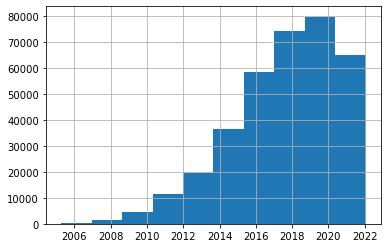

In [9]:
# Distribution of date
df.date.hist()

In [10]:
# Find the top 10 categories
print('Top 10 categories:')
df_explode.categories.value_counts()[:10]

Top 10 categories:


Restaurants                  34987
Food                         20419
Shopping                     20186
Home Services                13322
Beauty & Spas                12263
Health & Medical             11046
Local Services               10138
Automotive                    9879
Nightlife                     8379
Event Planning & Services     8173
Name: categories, dtype: int64